# Funance Blog Vol.2 - Intro to BONDS

In [1]:
# import dependencies
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy as sp

In [2]:
# canadian bond data
# taken from https://www.cnbc.com/canada-government-bonds/
# couldnt find a way to download all the data at once so i had to do it manually...

# date the data was taken
record_date = datetime.strptime("2024-05-21", "%Y-%m-%d")

bond_data = {
    'bond_name': [
        'CAN 1-MO',
        'CAN 3-MO',
        'CAN 1-YR',
        'CAN 3-YR',
        'CAN 4-YR',
        'CAN 5-YR',
        'CAN 10-YR',
        'CAN 20-YR',
        'CAN 30-YR',
    ],
    
    'date': [
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21',
        '2024-05-21', 
    ],
    
    'price': [
        99.787,
        98.87,
        95.863,
        93.471,
        96.748,
        101.563,
        95.118,
        105.487,
        68.555
    ],
    
    'maturity': [
        '2024-06-06',
        '2024-08-15',
        '2025-04-24',
        '2026-09-01',
        '2027-09-01',
        '2029-03-01',
        '2034-06-01',
        '2041-06-01',
        '2053-12-01'
        
    ],
    
    'coupon': [
        0.00,
        0.00,
        0.00,
        1.00,
        2.75,
        4.00,
        3.00,
        4.00,
        1.75 
    ],
    
    'yield': [
        4.875,
        4.86,
        4.66,
        4.032,
        3.815,
        3.639,
        3.584,
        3.567,
        3.458
    ],
}

In [3]:
# convert data to dataframe
bond_df = pd.DataFrame(bond_data)

bond_df

,bond_name,date,price,maturity,coupon,yield
0,CAN 1-MO,2024-05-21,99.787,2024-06-06,0.00,4.875
1,CAN 3-MO,2024-05-21,98.870,2024-08-15,0.00,4.860
2,CAN 1-YR,2024-05-21,95.863,2025-04-24,0.00,4.660
3,CAN 3-YR,2024-05-21,93.471,2026-09-01,1.00,4.032
4,CAN 4-YR,2024-05-21,96.748,2027-09-01,2.75,3.815
5,CAN 5-YR,2024-05-21,101.563,2029-03-01,4.00,3.639
6,CAN 10-YR,2024-05-21,95.118,2034-06-01,3.00,3.584
7,CAN 20-YR,2024-05-21,105.487,2041-06-01,4.00,3.567
8,CAN 30-YR,2024-05-21,68.555,2053-12-01,1.75,3.458


In [4]:
# calculate the dirty price
# dirty price = clean price + accrued interest
# accrued interest = (days since last coupon payment / days in coupon period) * coupon payment
# Canadian government bonds pay semi-annual coupons

bond_df['maturity'] = pd.to_datetime(bond_df['maturity'])
bond_df['date'] = pd.to_datetime(bond_df['date'])

# calculate next coupon date
next_coupon_date = []
for i in bond_df['maturity']:
    date = i.replace(year=record_date.year)
    
    if date + timedelta(days=182.625) < record_date:
        next_coupon_date.append(i.replace(year=record_date.year, month=i.month+12))
    elif date < record_date:
        next_coupon_date.append(i.replace(year=record_date.year, month=i.month+6))
    elif date - timedelta(days=182.625) > record_date:
        next_coupon_date.append(i.replace(year=record_date.year, month=i.month-6))
    else:
        next_coupon_date.append(i.replace(year=record_date.year))

bond_df['next_coupon_date'] = next_coupon_date
bond_df['days_to_coupon'] = (bond_df['next_coupon_date'] - record_date).dt.days
bond_df['dirty_price'] = bond_df['price'] + (bond_df['coupon'] / 2) * ((182.625 - bond_df['days_to_coupon']) / 182.625)
    

In [5]:
# rearrange columns
bond_df = bond_df.loc[:, ['bond_name', 'date', 'price', 'dirty_price', 'maturity', 'coupon', 'days_to_coupon', 'next_coupon_date', 'yield']]

bond_df[['bond_name', 'price', 'dirty_price', 'days_to_coupon', 'next_coupon_date']]

,bond_name,price,dirty_price,days_to_coupon,next_coupon_date
0,CAN 1-MO,99.787,99.787000,16,2024-06-06
1,CAN 3-MO,98.870,98.870000,86,2024-08-15
2,CAN 1-YR,95.863,95.863000,156,2024-10-24
3,CAN 3-YR,93.471,93.689001,103,2024-09-01
4,CAN 4-YR,96.748,97.347504,103,2024-09-01
5,CAN 5-YR,101.563,102.435005,103,2024-09-01
6,CAN 10-YR,95.118,96.527651,11,2024-06-01
7,CAN 20-YR,105.487,107.366535,11,2024-06-01
8,CAN 30-YR,68.555,69.377296,11,2024-06-01


In [6]:
# cashflow of each bond
cashflows = {}
for _, row in bond_df.iterrows():
    cashflow_df = pd.DataFrame(columns=['date', 'cashflow'])
    
    # append negative cashflow for buying
    coupon_date = row['next_coupon_date']
    coupon = row['coupon'] / 2
    date = [row['date'].date()]
    cashflow = [-row.dirty_price]

    # append coupon payouts
    while coupon_date < row['maturity']:
        date.append(coupon_date.date()) 
        cashflow.append(coupon)
        coupon_date = coupon_date + timedelta(days=182.625)
        
    # append final coupon and principal
    date.append(row['maturity'].date())
    cashflow.append(coupon + 100)
    
    cashflow_df['date'] = date
    cashflow_df['cashflow'] = cashflow
    
    cashflows[row['bond_name']] = cashflow_df

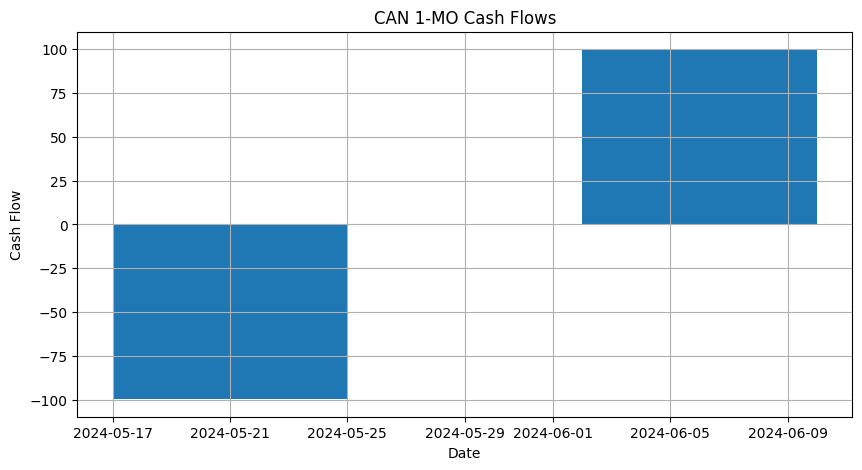

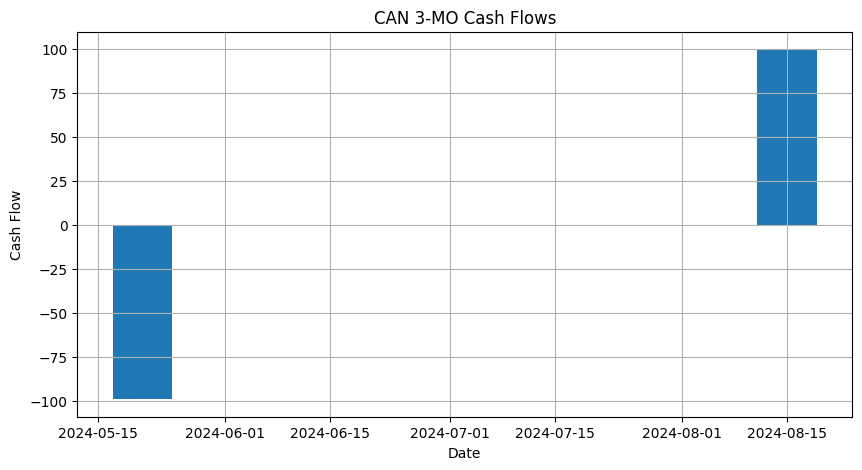

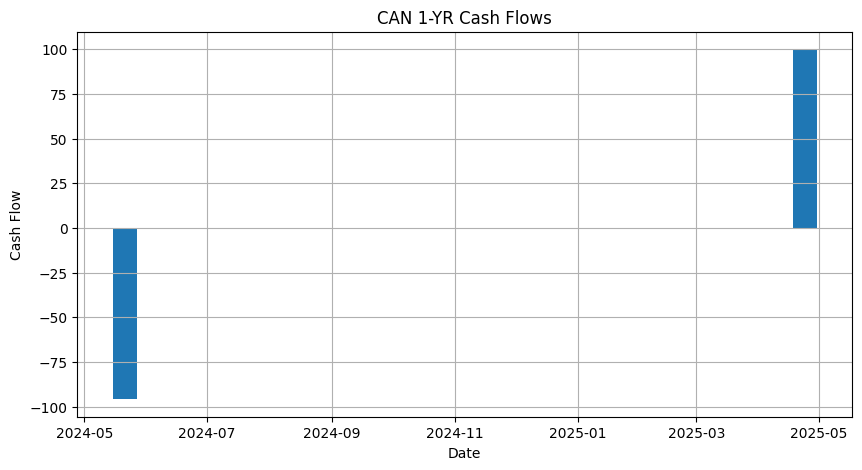

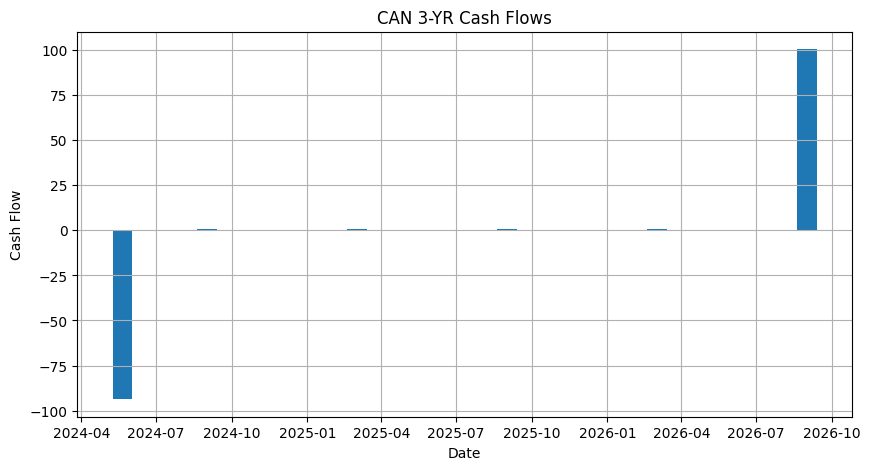

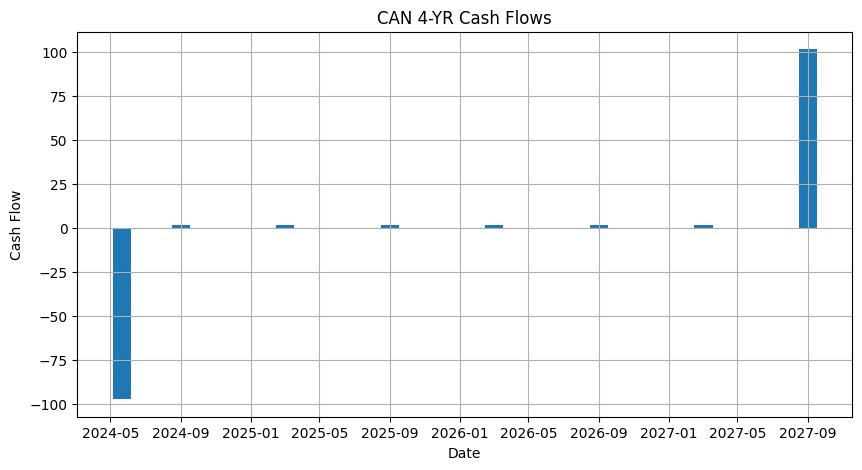

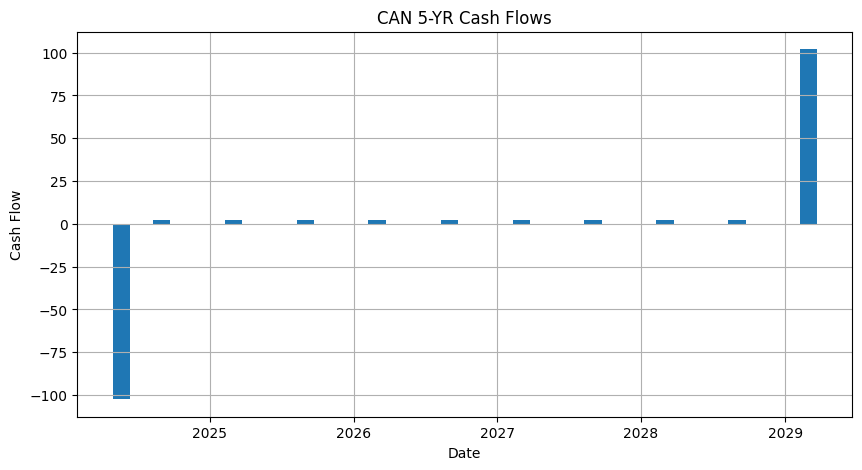

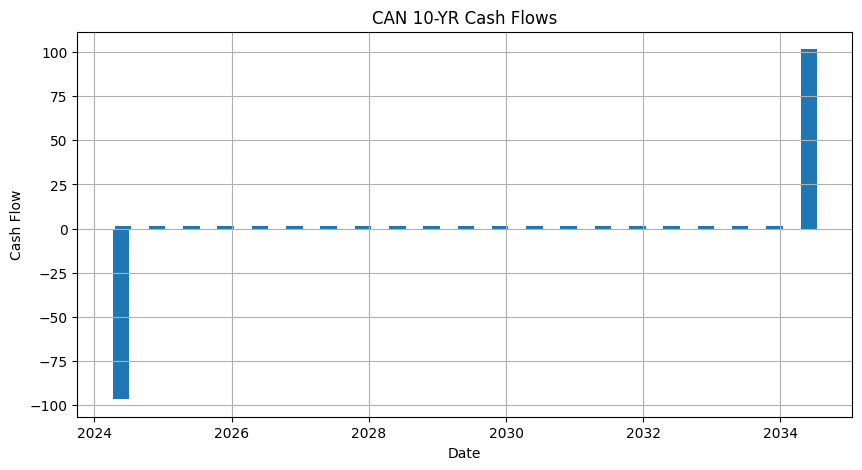

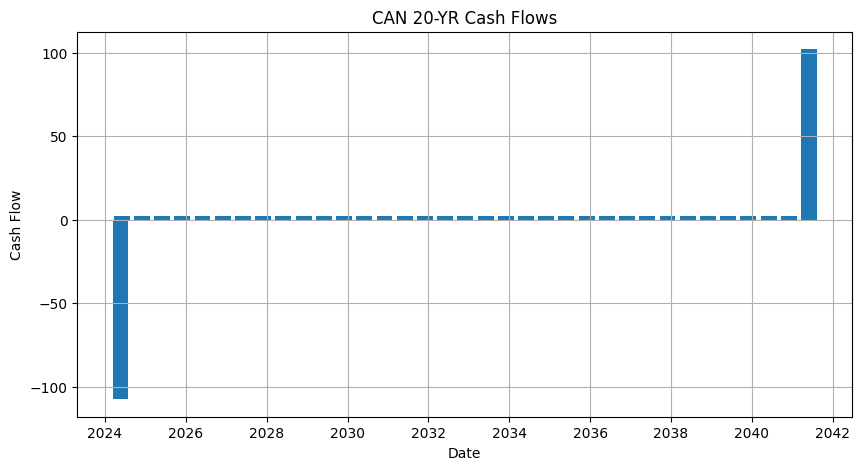

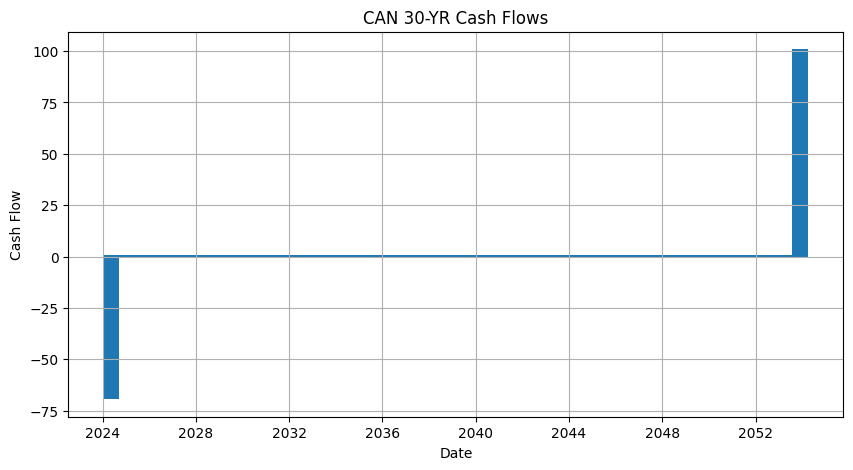

In [7]:
# plotting cash flows as bar graph
for bond in bond_df['bond_name']:
    plt.figure(figsize=(10, 5))
    plt.bar(cashflows[bond]['date'], cashflows[bond]['cashflow'], width = 4*len(cashflows[bond]['date']))
    plt.title(f'{bond} Cash Flows')
    plt.xlabel('Date')
    plt.ylabel('Cash Flow')
    plt.grid()
    plt.show() 


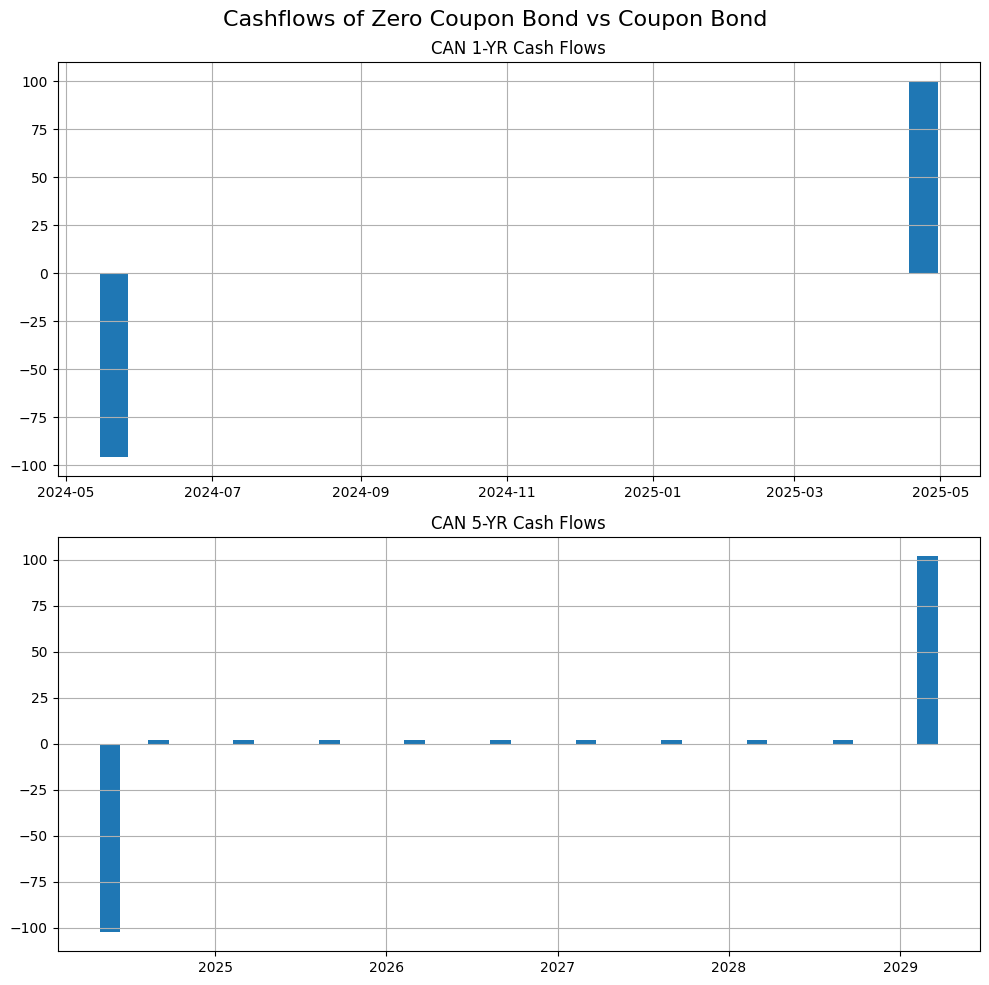

In [8]:
# closer look at zero coupon bond vs coupon bond
zero_coupon_bond = 'CAN 1-YR'
coupon_bond = 'CAN 5-YR'

figs, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].bar(cashflows[zero_coupon_bond]['date'], cashflows[zero_coupon_bond]['cashflow'], width=4*len(cashflows[zero_coupon_bond]['date']), label='Zero Coupon Bond')
axs[0].set_title(f'{zero_coupon_bond} Cash Flows')
axs[0].grid()
axs[1].bar(cashflows[coupon_bond]['date'], cashflows[coupon_bond]['cashflow'], width=4*len(cashflows[coupon_bond]['date']), label='Coupon Bond')
axs[1].set_title(f'{coupon_bond} Cash Flows')
axs[1].grid()

figs.suptitle('Cashflows of Zero Coupon Bond vs Coupon Bond', fontsize=16)
figs.tight_layout()

In [9]:
# calculate yield to maturity
yields = []

for bond in bond_df['bond_name']:
    bond_cashflow_df = cashflows[bond]
    t_0 = bond_cashflow_df.loc[0, 'date']
   
    def bond_yield(y: float) -> float:
        p_t = bond_cashflow_df.loc[0, 'cashflow']
       
        for _, (t, c_t) in bond_cashflow_df[1:].iterrows():
           p_t += c_t / (1 + y) ** ((t - t_0).days / 182.625)
           
        return p_t
    
    yield_to_maturity = opt.fsolve(bond_yield, 0)[0]
    
    # since the bonds pay semi-annual coupons, multiply by 2 to get annual yield
    yields.append(round(yield_to_maturity*2 * 100, 3))
    
bond_df['calculated_yield'] = yields
bond_df['yield_diff_%'] = np.abs((bond_df['yield'] - bond_df['calculated_yield']) / bond_df['yield'])*100

In [10]:
bond_df[['bond_name', 'yield', 'calculated_yield', 'yield_diff_%']]

,bond_name,yield,calculated_yield,yield_diff_%
0,CAN 1-MO,4.875,4.927,1.066667
1,CAN 3-MO,4.860,4.885,0.514403
2,CAN 1-YR,4.660,4.618,0.901288
3,CAN 3-YR,4.032,4.025,0.173611
4,CAN 4-YR,3.815,3.815,0.000000
5,CAN 5-YR,3.639,3.643,0.109920
6,CAN 10-YR,3.584,3.584,0.000000
7,CAN 20-YR,3.567,3.567,0.000000
8,CAN 30-YR,3.458,3.480,0.636206


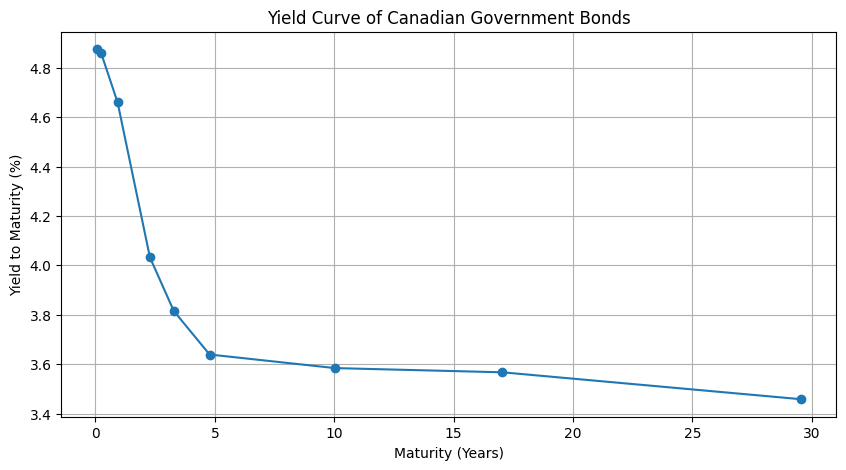

In [11]:
# yield curve
maturity = (bond_df['maturity'] - record_date).dt.days / 365

plt.figure(figsize=(10, 5))
plt.plot(maturity, bond_df['yield'], marker='o')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield to Maturity (%)')
plt.title('Yield Curve of Canadian Government Bonds')
plt.grid()
plt.show()

In [12]:
# Macaulay Duration
def macaulay_duration(c_t: np.array, t_i: np.array, p: float, y: float) -> float:
    """ Calculates the Macaulay Duration of a bond

    Args:
        c_t (np.array): array of cashflows at time t
        t_i (np.array): array of times when cashflows are received
        p (float): current price of the bond (dirty price)
        y (float): yield to maturity of the bond

    Returns:
        float: Macaulay Duration of the bond
    """
    return np.sum((t_i * c_t / (1 + y) ** t_i) / p)
    
    

In [13]:
# Modified Duration
def modified_duration(d_mac: float, y: float) -> float:
    """ Calculates the Modified Duration of a bond

    Args:
        d_mac (float): Macaulay Duration of the bond
        y (float): yield to maturity of the bond

    Returns:
        float: Modified Duration of the bond
    """
    return d_mac / (1 + y)

In [14]:
# convexity
def convexity(c_t: np.array, t_i: np.array, p: float, y: float) -> float:
    """ Calculates the Convexity of a bond

    Args:
        c_t (np.array): array of cashflows at time t
        t_i (np.array): array of times when cashflows are received
        p (float): current price of the bond (dirty price)
        y (float): yield to maturity of the bond

    Returns:
        float: Convexity of the bond
    """
    return np.sum((t_i * (t_i + 1) * c_t / (1 + y) ** (t_i + 2)) / p)

In [15]:
# compute Macaulay, Modified Duration, and Convexity for each bond
for i, row in bond_df.iterrows():
    y = row['yield'] / 100
    p = row['dirty_price']
    
    # do not include the initial negative cashflow for buying the bond in the calculation
    cashflow_df = cashflows[row['bond_name']]
    c_t = cashflow_df['cashflow'].values[1:]
    t_i = np.arange(1, len(c_t)+1)
    
    d_mac = macaulay_duration(c_t, t_i, p, y)
    d_mod = modified_duration(d_mac, y)
    conv = convexity(c_t, t_i, p, y)
    
    bond_df.loc[i, 'macaulay_duration'] = d_mac
    bond_df.loc[i, 'modified_duration'] = d_mod    
    bond_df.loc[i, 'convexity'] = conv

In [16]:
bond_df[['bond_name', 'macaulay_duration', 'modified_duration', 'convexity']]

,bond_name,macaulay_duration,modified_duration,convexity
0,CAN 1-MO,0.955551,0.911134,1.737561
1,CAN 3-MO,0.964552,0.919847,1.754429
2,CAN 1-YR,1.904660,1.819855,5.216477
3,CAN 3-YR,4.449059,4.276626,24.575835
4,CAN 4-YR,5.861565,5.646164,42.864635
5,CAN 5-YR,7.667817,7.398582,76.010678
6,CAN 10-YR,12.588058,12.152512,242.485075
7,CAN 20-YR,14.915776,14.402054,430.915792
8,CAN 30-YR,17.796829,17.201985,855.234719


In [17]:
# price change from ytm change
delta_r = 0.01 # assume 1% change in yield change

# 1st order approximation (duration)
bond_df['delta_price_1'] = -bond_df['modified_duration'] * delta_r

# 2nd order approximation (duration + convexity)
bond_df['delta_price_2'] = -bond_df['modified_duration'] * delta_r + 0.5 * bond_df['convexity'] * (delta_r ** 2)

In [18]:
bond_df[['bond_name', 'delta_price_1', 'delta_price_2']]

,bond_name,delta_price_1,delta_price_2
0,CAN 1-MO,-0.009111,-0.009024
1,CAN 3-MO,-0.009198,-0.009111
2,CAN 1-YR,-0.018199,-0.017938
3,CAN 3-YR,-0.042766,-0.041537
4,CAN 4-YR,-0.056462,-0.054318
5,CAN 5-YR,-0.073986,-0.070185
6,CAN 10-YR,-0.121525,-0.109401
7,CAN 20-YR,-0.144021,-0.122475
8,CAN 30-YR,-0.172020,-0.129258


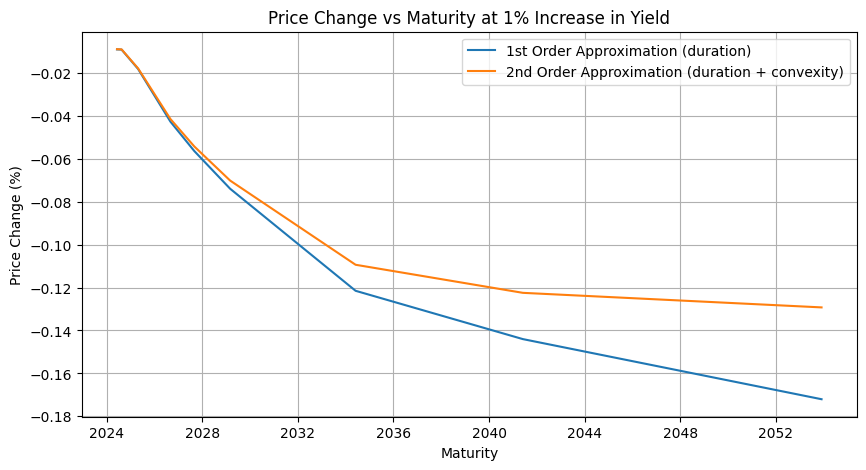

In [19]:
# plotting duration and convexity
plt.figure(figsize=(10, 5))
plt.plot(bond_df['maturity'], bond_df['delta_price_1'], label='1st Order Approximation (duration)')
plt.plot(bond_df['maturity'], bond_df['delta_price_2'], label='2nd Order Approximation (duration + convexity)')
plt.xlabel('Maturity')
plt.ylabel('Price Change (%)')
plt.title('Price Change vs Maturity at 1% Increase in Yield')
plt.legend()
plt.grid()
plt.show()